<a href="https://colab.research.google.com/github/AleksandrRevuka/HW_Data_Science/blob/main/Hw9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
import tensorflow as tf

from keras import layers
from keras.metrics import Precision, Recall, F1Score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Adamax, Ftrl
from keras.datasets import fashion_mnist
from keras.callbacks import History, Callback

In [16]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.clf()
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

In [17]:
def plot_precision_recall(history):
    precision_values = [history.history[f'precision_class_{i}'][-1] for i in range(10)]
    recall_values = [history.history[f'recall_class_{i}'][-1] for i in range(10)]

    classes = [str(i) for i in range(10)]
    width = 0.35
    x = range(len(classes))

    plt.figure(figsize=(12, 6))

    plt.bar(x, precision_values, width, label='Precision')
    plt.bar([i + width for i in x], recall_values, width, label='Recall')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision and Recall for Each Class')
    plt.xticks([i + width/2 for i in x], classes)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.grid(axis='y', linestyle='--')

    plt.show()

In [18]:
clothing_classes = 10
n_hidden_1 = 64
n_hidden_2 = 128
n_hidden_3 = 256
epochs = 10

In [19]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

train_data, test_data = train_data / 255., test_data / 255.

train_labels_one_hot = to_categorical(train_labels, num_classes=clothing_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=clothing_classes)

In [20]:
precision_per_class = [Precision(class_id=i, name=f'precision_class_{i}') for i in range(clothing_classes)]
recall_per_class = [Recall(class_id=i, name=f'recall_class_{i}') for i in range(clothing_classes)]

all_metrics = ['accuracy'] + precision_per_class + recall_per_class

In [21]:
def build_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(n_hidden_3, activation='relu'),
        Dense(n_hidden_2, activation='relu'),
        Dense(n_hidden_1, activation='relu'),
        Dense(clothing_classes, activation='softmax'),
    ])

    model.compile(
        optimizer=Adamax(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=all_metrics
    )
    return model

In [22]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
Total params: 242762 (948.29 KB)
Trainable params: 242762 (948.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
history = model.fit(train_data,
                    train_labels_one_hot,
                    validation_data=(test_data, test_labels_one_hot),
                    epochs=10,
                    batch_size=32)


Epoch 1/10
1875/1875 [==============================] - 8s 3ms/step - loss: 0.5119 - accuracy: 0.8199 - precision_class_0: 0.8238 - precision_class_1: 0.9842 - precision_class_2: 0.7682 - precision_class_3: 0.8744 - precision_class_4: 0.7356 - precision_class_5: 0.9525 - precision_class_6: 0.6902 - precision_class_7: 0.9018 - precision_class_8: 0.9590 - precision_class_9: 0.9164 - recall_class_0: 0.7300 - recall_class_1: 0.9342 - recall_class_2: 0.6070 - recall_class_3: 0.7762 - recall_class_4: 0.6323 - recall_class_5: 0.8323 - recall_class_6: 0.3732 - recall_class_7: 0.8735 - recall_class_8: 0.9208 - recall_class_9: 0.9187 - val_loss: 0.4252 - val_accuracy: 0.8459 - val_precision_class_0: 0.8382 - val_precision_class_1: 0.9765 - val_precision_class_2: 0.7219 - val_precision_class_3: 0.8530 - val_precision_class_4: 0.8283 - val_precision_class_5: 0.9514 - val_precision_class_6: 0.7798 - val_precision_class_7: 0.9456 - val_precision_class_8: 0.9672 - val_precision_class_9: 0.9269 - val_

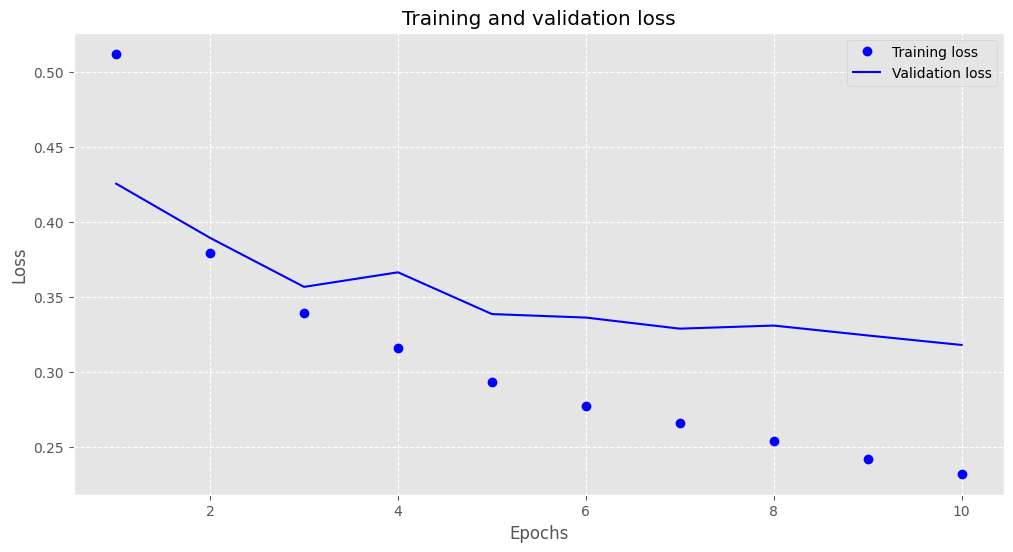

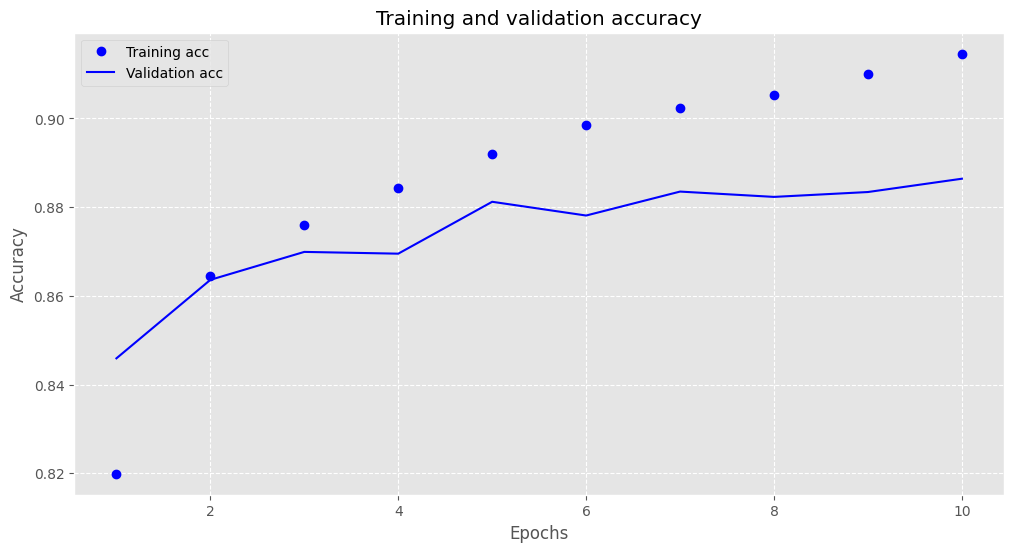

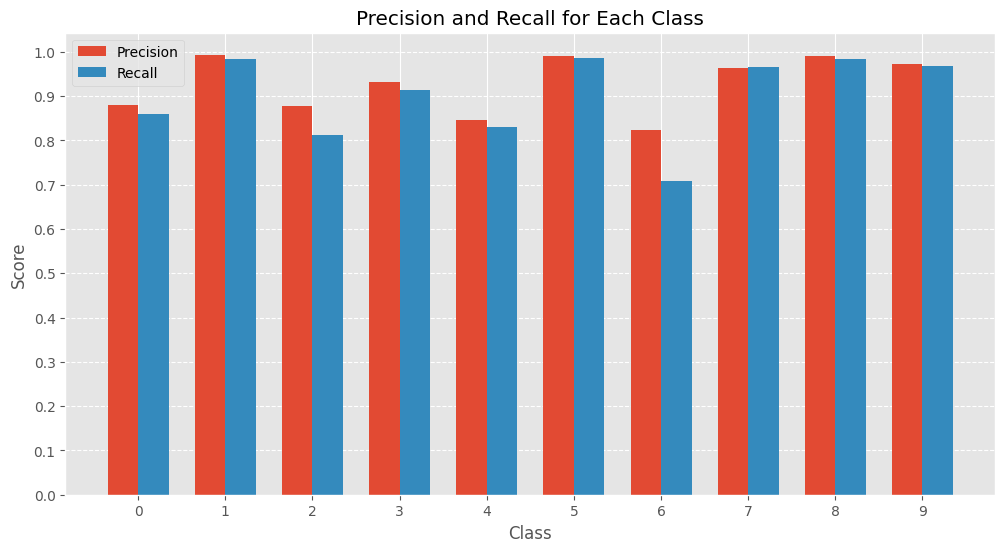

In [24]:
plot_history(history)
plot_precision_recall(history)

In [25]:
results = model.evaluate(test_data, test_labels_one_hot)
print(f"val_accuracy:{results[1]}")

313/313 [==============================] - 1s 2ms/step - loss: 0.3177 - accuracy: 0.8864 - precision_class_0: 0.8833 - precision_class_1: 0.9969 - precision_class_2: 0.8367 - precision_class_3: 0.9103 - precision_class_4: 0.8301 - precision_class_5: 0.9847 - precision_class_6: 0.7004 - precision_class_7: 0.9288 - precision_class_8: 0.9906 - precision_class_9: 0.9691 - recall_class_0: 0.8020 - recall_class_1: 0.9550 - recall_class_2: 0.7790 - recall_class_3: 0.8630 - recall_class_4: 0.7720 - recall_class_5: 0.9630 - recall_class_6: 0.7410 - recall_class_7: 0.9780 - recall_class_8: 0.9520 - recall_class_9: 0.9410
val_accuracy:0.8863999843597412


Вручну вдалося добитися accuracy: 0.8864 на валідаційних данних але не 0.91!

# Автоматичний підбір гіперпараметрів: #

In [26]:
class MyAutoModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Flatten())
        for i in range(hp.Int("num_layers", 2, 4)):
            model.add(
                Dense(
                    units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                    activation="relu"
                )
            )

        if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.25))
        model.add(Dense(10, activation="softmax"))

        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss="categorical_crossentropy",
            metrics=all_metrics
        )
        return model

    def fit(self, hp, model, x, y, validation_data, **kwargs):
        if hp.Boolean("normalize"):
            x = layers.Normalization()(x)
        return model.fit(
            x,
            y,
            validation_data=validation_data,
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )


In [27]:
tuner = keras_tuner.RandomSearch(
    MyAutoModel(),
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
)


In [28]:
tuner.search(train_data,
             train_labels_one_hot,
             epochs=epochs,
             validation_data=(test_data, test_labels_one_hot),
             batch_size=32)

Trial 5 Complete [00h 01m 05s]
val_accuracy: 0.8711000084877014

Best val_accuracy So Far: 0.8766000270843506
Total elapsed time: 00h 04m 40s


In [29]:
automodel = MyAutoModel()
best_hp = tuner.get_best_hyperparameters()[0]
model_auto = automodel.build(best_hp)
history = automodel.fit(best_hp,
                        model_auto,
                        train_data,
                        train_labels_one_hot,
                        validation_data=(test_data, test_labels_one_hot),
                        epochs=10,
                        batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.5381 - accuracy: 0.8132 - precision_class_0: 0.8161 - precision_class_1: 0.9837 - precision_class_2: 0.7900 - precision_class_3: 0.8759 - precision_class_4: 0.7381 - precision_class_5: 0.9558 - precision_class_6: 0.7151 - precision_class_7: 0.8961 - precision_class_8: 0.9636 - precision_class_9: 0.9229 - recall_class_0: 0.7346 - recall_class_1: 0.9243 - recall_class_2: 0.5717 - recall_class_3: 0.7784 - recall_class_4: 0.6560 - recall_class_5: 0.8271 - recall_class_6: 0.3764 - recall_class_7: 0.8703 - recall_class_8: 0.9089 - recall_class_9: 0.9029 - val_loss: 0.4591 - val_accuracy: 0.8373 - val_precision_class_0: 0.8454 - val_precision_class_1: 0.9845 - val_precision_class_2: 0.6537 - val_precision_class_3: 0.8124 - val_precision_class_4: 0.8424 - val_precision_class_5: 0.9626 - val_precision_class_6: 0.8362 - val_precision_class_7: 0.8946 - val_precision_class_8: 0.9505 - val_precision_class_9: 0.9691 - val_

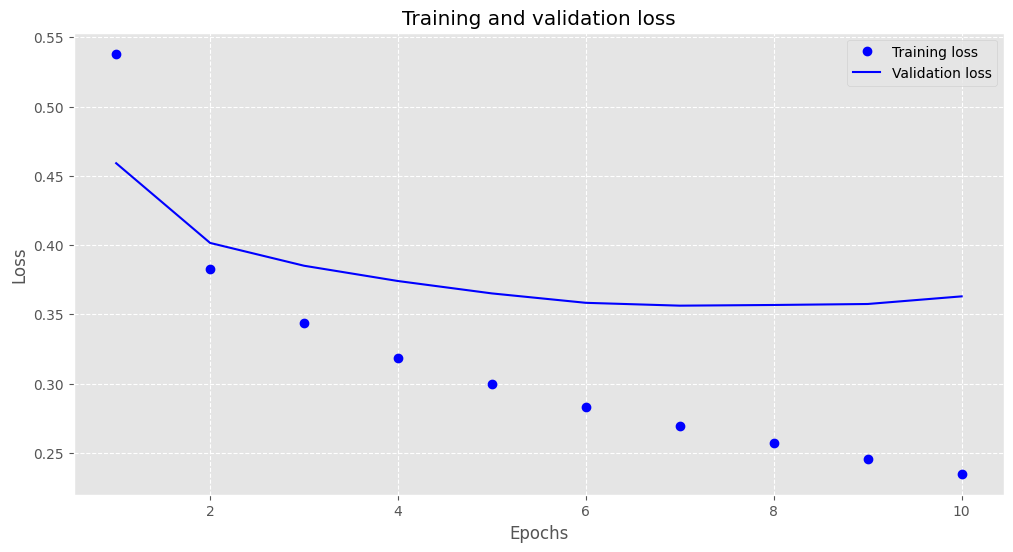

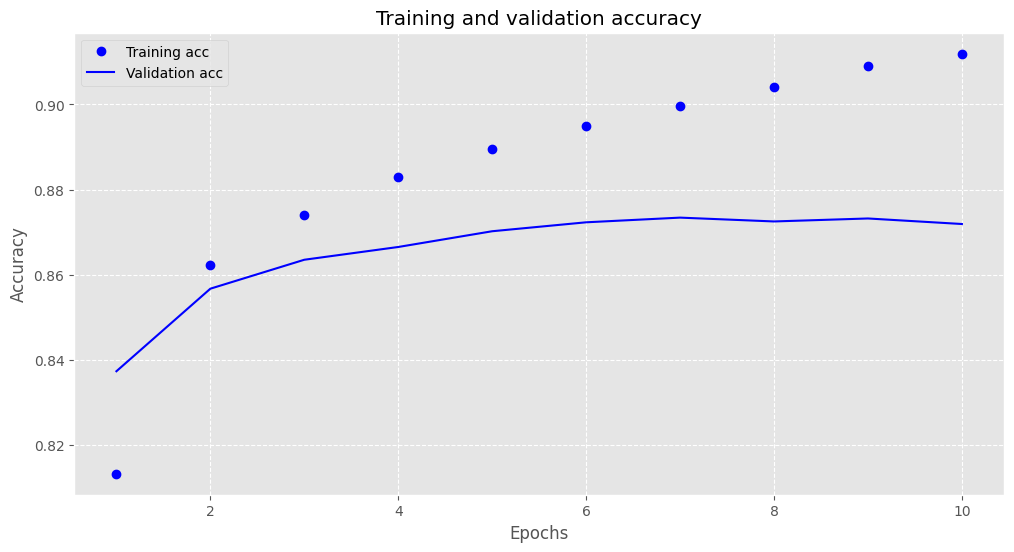

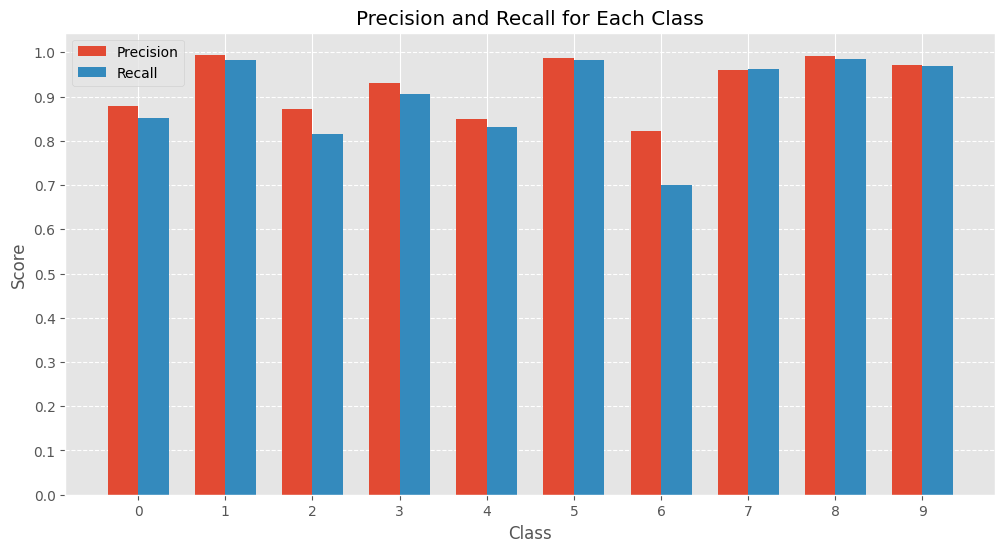

In [30]:
plot_history(history)
plot_precision_recall(history)

In [31]:
results = model_auto.evaluate(test_data, test_labels_one_hot)
print(results)

313/313 [==============================] - 1s 2ms/step - loss: 0.3630 - accuracy: 0.8719 - precision_class_0: 0.8310 - precision_class_1: 0.9827 - precision_class_2: 0.8483 - precision_class_3: 0.8917 - precision_class_4: 0.7079 - precision_class_5: 0.9800 - precision_class_6: 0.8438 - precision_class_7: 0.9219 - precision_class_8: 0.9718 - precision_class_9: 0.9509 - recall_class_0: 0.8410 - recall_class_1: 0.9680 - recall_class_2: 0.6820 - recall_class_3: 0.8810 - recall_class_4: 0.8990 - recall_class_5: 0.9320 - recall_class_6: 0.4970 - recall_class_7: 0.9680 - recall_class_8: 0.9650 - recall_class_9: 0.9490
[0.36299416422843933, 0.8719000220298767, 0.8310276865959167, 0.982741117477417, 0.8482587337493896, 0.8917003870010376, 0.7078740000724792, 0.980021059513092, 0.8438030481338501, 0.9219047427177429, 0.9718025922775269, 0.9509018063545227, 0.8410000205039978, 0.9679999947547913, 0.6819999814033508, 0.8809999823570251, 0.8989999890327454, 0.9319999814033508, 0.4970000088214874, 0

Автоматично підбираючи кількість нейронів та шарів вдалося добитися accuracy: 0.8719 на валідаційних данних але не 0.91

# Фільтр Conv2D: #

In [32]:
class MyFilterModel(keras_tuner.HyperModel):
  def build(self, hp):
    model = Sequential([
      Conv2D(
          filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
          kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
          activation='relu',
          input_shape=(28,28,1)
      ),
      Conv2D(
          filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
          kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
          activation='relu'
      ),
      Flatten(),
      Dense(
          units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
          activation='relu'
      ),
      Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='categorical_crossentropy',
                metrics=all_metrics)

    return model

  def fit(self, hp, model, x, y, validation_data, **kwargs):
    if hp.Boolean("normalize"):
      x = layers.Normalization()(x)
    return model.fit(
      x,
      y,
      validation_data=validation_data,
      shuffle=hp.Boolean("shuffle"),
      **kwargs,)

In [33]:
tuner = keras_tuner.RandomSearch(
    MyFilterModel(),
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
)

In [34]:
tuner.search(train_data,
             train_labels_one_hot,
             epochs=5,
             validation_data=(test_data, test_labels_one_hot),
             batch_size=32)

Trial 5 Complete [00h 04m 08s]
val_accuracy: 0.9121999740600586

Best val_accuracy So Far: 0.9172999858856201
Total elapsed time: 00h 23m 29s


In [38]:
filtermodel = MyFilterModel()
best_hp = tuner.get_best_hyperparameters()[0]
model_filter = filtermodel.build(best_hp)
history = filtermodel.fit(best_hp,
                        model_filter,
                        train_data,
                        train_labels_one_hot,
                        validation_data=(test_data, test_labels_one_hot),
                        epochs=3,
                        batch_size=32)

Epoch 1/3
1875/1875 [==============================] - 45s 23ms/step - loss: 0.3788 - accuracy: 0.8632 - precision_class_0: 0.8378 - precision_class_1: 0.9887 - precision_class_2: 0.8281 - precision_class_3: 0.8991 - precision_class_4: 0.8024 - precision_class_5: 0.9705 - precision_class_6: 0.7428 - precision_class_7: 0.9327 - precision_class_8: 0.9755 - precision_class_9: 0.9490 - recall_class_0: 0.7999 - recall_class_1: 0.9653 - recall_class_2: 0.7544 - recall_class_3: 0.8634 - recall_class_4: 0.7507 - recall_class_5: 0.9431 - recall_class_6: 0.5666 - recall_class_7: 0.9233 - recall_class_8: 0.9493 - recall_class_9: 0.9444 - val_loss: 0.2994 - val_accuracy: 0.8888 - val_precision_class_0: 0.9114 - val_precision_class_1: 0.9969 - val_precision_class_2: 0.8207 - val_precision_class_3: 0.8900 - val_precision_class_4: 0.9135 - val_precision_class_5: 0.9918 - val_precision_class_6: 0.6899 - val_precision_class_7: 0.9304 - val_precision_class_8: 0.9799 - val_precision_class_9: 0.9692 - val

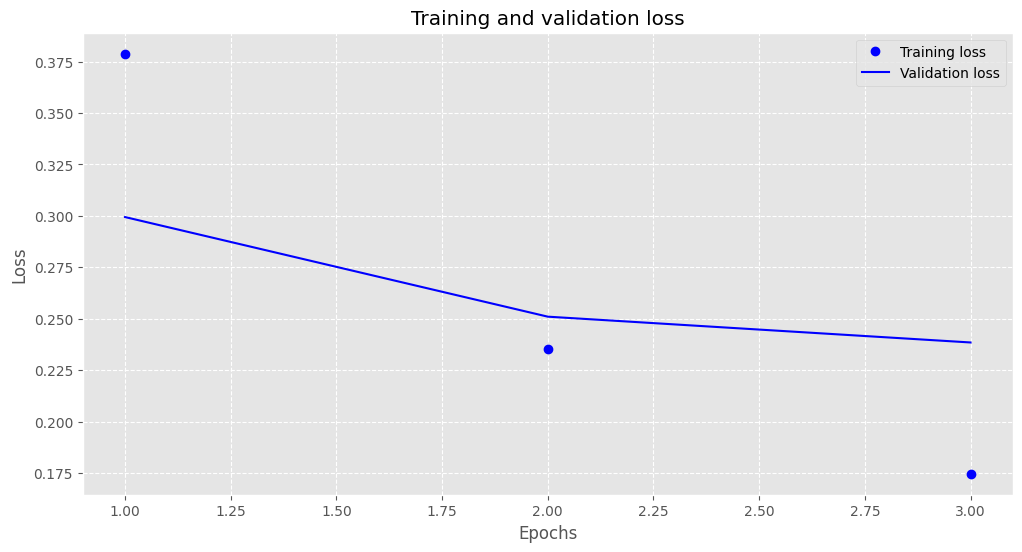

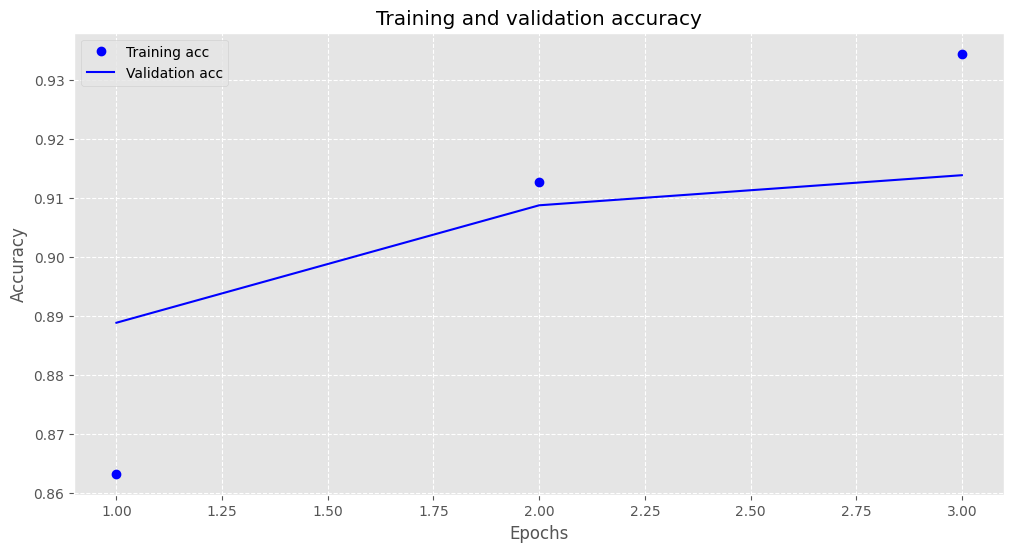

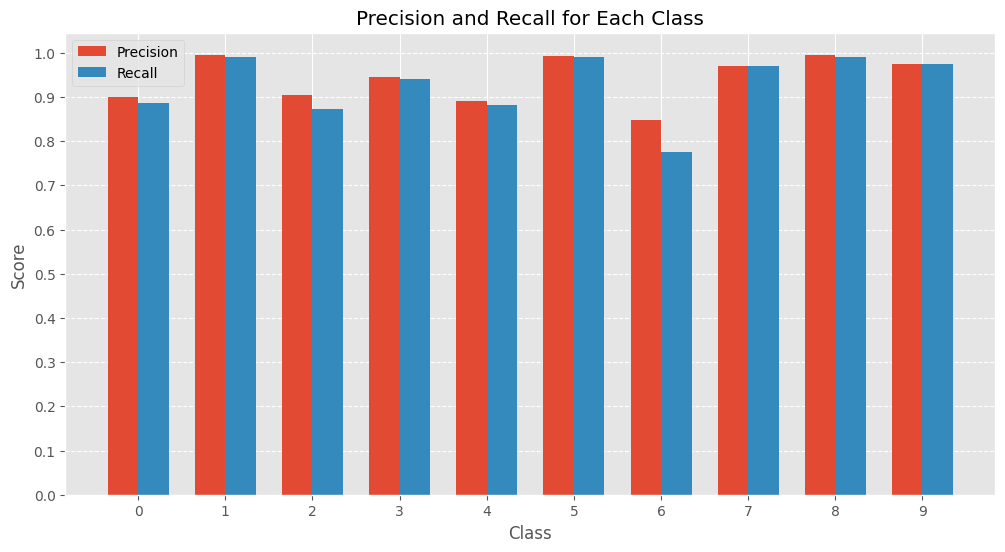

In [39]:
plot_history(history)
plot_precision_recall(history)

In [40]:
results = model_filter.evaluate(test_data, test_labels_one_hot)
print(results)

313/313 [==============================] - 2s 5ms/step - loss: 0.2384 - accuracy: 0.9138 - precision_class_0: 0.9030 - precision_class_1: 0.9959 - precision_class_2: 0.8959 - precision_class_3: 0.9524 - precision_class_4: 0.8521 - precision_class_5: 0.9889 - precision_class_6: 0.7567 - precision_class_7: 0.9558 - precision_class_8: 0.9949 - precision_class_9: 0.9747 - recall_class_0: 0.8100 - recall_class_1: 0.9780 - recall_class_2: 0.8350 - recall_class_3: 0.8800 - recall_class_4: 0.8760 - recall_class_5: 0.9780 - recall_class_6: 0.7620 - recall_class_7: 0.9720 - recall_class_8: 0.9680 - recall_class_9: 0.9650
[0.23844899237155914, 0.9138000011444092, 0.9030100107192993, 0.9959266781806946, 0.8959227204322815, 0.9523809552192688, 0.8521400690078735, 0.9888776540756226, 0.7567030787467957, 0.9557521939277649, 0.9948612451553345, 0.9747474789619446, 0.8100000023841858, 0.9779999852180481, 0.8349999785423279, 0.8799999952316284, 0.8759999871253967, 0.9779999852180481, 0.7620000243186951,

In [41]:
model_filter.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 96)        960       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        27680     
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 112)               2064496   
                                                                 
 dense_5 (Dense)             (None, 10)                1130      
                                                                 
Total params: 2094266 (7.99 MB)
Trainable params: 2094266 (7.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Висновки: #

Добавивши два шари Conv2D згорткової нейронної мережі з бібліотеки Keras. Цей шар ефективно працює з двовимірними даними, такими як чорно-білі або кольорові зображення. Мені вдалося досягти accuracy: 0.9122 на валідаційних данних.

При ручному підборі гіперпараметрів видно, що в деяких класах точність та повнота були низькі, особливо повнота. Після використання шару Conv2D значення стали близькими до середнього, але все одно в шостому класі повнота залишається низькою. 

Думки:
Сокіше завсе потрібно покращити існуючий навчальний датасет шостого класу, або збільшити його.